# Predicting county flips in presidential election

Bayu Wilson

Importing useful libraries

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import requests

Defining useful functions

In [2]:
def get_swing_counties(group,swing_threshold=0.05):
    """
    County is a swing county if the margin between the top two candidates were < `swing_threshold`.
    group: a pandas groupby object
    swing_threshold: threshold such that a margin below this number is classified as a swing county
    is_swing: boolean for whether or not the county is a swing county
    """
    top_two = group.nlargest(2, 'candidatevotes')
    total_top_two = top_two['candidatevotes'].sum()
    margin = np.abs(np.diff(top_two['candidatevotes']/total_top_two)[0])
    # if np.max(top_two) > 100_000:
    is_swing = (margin<swing_threshold)
    return is_swing

# Function to fetch and process data
def fetch_census_data(url):
    response = requests.get(url)
    data = response.json()
    columns = data[0]
    df = pd.DataFrame(data[1:], columns=columns)
    return df

In [3]:
### loading presidenial election results
df = pd.read_csv("data/dataverse_files/countypres_2000-2020.csv") #presidential election results from MIT Election Lab
df.drop(columns=["state","office","version","candidate","mode"],inplace=True) #dropping useless information
df.dropna(inplace=True) #ignoring nan values
df = df[df.candidatevotes>0] #ignoring rows with no votes. 
df['county_fips'] = df['county_fips'].astype(int).astype(str).str.zfill(5)
swing_counties = df.groupby(['year', 'county_fips']).apply(get_swing_counties).reset_index(name='swing')
df = df.merge(swing_counties,on=['year', 'county_fips']) #adding swing classification to main dataframe

### Getting presidential winners for each year
df_winners_by_year = df.loc[df.groupby(['year','county_fips'])["candidatevotes"].idxmax()] #find county election winner (most votes)
df_winners_by_year = pd.get_dummies(df_winners_by_year, columns=['party']) #one-hot encodes which party won (D or R)
df_winners_by_year = df_winners_by_year.drop(columns=["party_REPUBLICAN"])
df_winners_by_year["party_DEMOCRAT"] = df_winners_by_year["party_DEMOCRAT"].astype(int)

In [4]:
### defining target (flipped county from last election) and adding column for if the county was previously a swing county
election_year_list = [2012,2016,2020]
df_elec = pd.DataFrame()
for i in range(1,len(election_year_list)):
    year_prev = election_year_list[i-1]
    year_curr = election_year_list[i]
    df_prev = df_winners_by_year[df_winners_by_year['year']==year_prev].copy().set_index('county_fips')
    df_curr = df_winners_by_year[df_winners_by_year['year']==year_curr].copy().set_index('county_fips')
    df_curr['flipped'] = df_curr['party_DEMOCRAT']-df_prev['party_DEMOCRAT']
    df_curr['swing_prev'] = df_prev['swing'].astype(int)
    df_curr['party_prev'] = df_prev['party_DEMOCRAT'].astype(int)
    df_curr.dropna(inplace=True)
    df_curr = df_curr.drop(columns=["state_po","county_name","swing","candidatevotes","party_DEMOCRAT"])
    #positive 1 means switched to D, -1 means switched to R, 0 means no change
    df_elec = pd.concat([df_elec,df_curr])
df_elec = df_elec.reset_index()
df_elec = df_elec.astype({"flipped":int,"swing_prev":int,"year":str,"party_prev":int})

`df_elec` is the first dataframe which mainly contains the target variable: `flipped`

In [5]:
print(np.unique(df_elec.county_fips).__len__())
df_elec.head()

3154


,county_fips,year,totalvotes,flipped,swing_prev,party_prev
0,01001,2016,24973,0,0,0
1,01003,2016,95215,0,0,0
2,01005,2016,10469,-1,1,1
3,01007,2016,8819,0,0,0
4,01009,2016,25588,0,0,0


In [6]:
df_elec_upcoming = df_winners_by_year[df_winners_by_year["year"] == 2020].reset_index(drop=True)
df_elec_upcoming["year"] = "2022"
df_elec_upcoming = df_elec_upcoming.rename(columns={"swing":"swing_prev"})
df_elec_upcoming = df_elec_upcoming.astype({"swing_prev":int})
df_elec_upcoming['party_prev'] = df_elec_upcoming['party_DEMOCRAT'].astype(int)
df_elec_upcoming = df_elec_upcoming.drop(columns=["state_po","county_name","candidatevotes","party_DEMOCRAT"])
df_elec_upcoming.head() #no flipped because we don't know it yet!

### we predict election as if it is happening in 2022. We assume total votes is same as 2020 election. 
#swing_prev tells us if county  was a swing county in 2020,
# party_democrat is from 2020

,year,county_fips,totalvotes,swing_prev,party_prev
0,2022,01001,27770,0,0
1,2022,01003,109679,0,0
2,2022,01005,10518,0,0
3,2022,01007,9595,0,0
4,2022,01009,27588,0,0


### loading data from DEC and ACS

| Source | Code           | Description                                                       |
|--------|----------------|-------------------------------------------------------------------|
| **DEC**| P001001        | Total population                                                  |
|        | P002002        | Urban population                                                  |
|        | P002005        | Rural population                                                  |
| **ACS**| B01003_001E    | Total population                                                  |
|        | B15003_022E    | Number of people aged 25 and older with a bachelor's degree or higher |
|        | B19301_001E    | Per capita income                                                 |
|        | B17001_002E    | Number of people whose income in the past 12 months is below the poverty level |
|        | B02001_002E    | Number of people identifying as "White alone"                     |
|        | B23025_005E    | Number of unemployed individuals (aged 16 and over)               |


In [7]:
### get rural/urban classification
dec_url = "https://api.census.gov/data/{}/dec/sf1?get=P001001,P002002,P002005,NAME&for=county:*"
df_dec = fetch_census_data(dec_url.format('2010'))
df_dec["rural"] = (df_dec["P002005"]>df_dec["P002002"]).astype(int)
df_dec["county_fips"] = df_dec["state"]+df_dec["county"]
df_dec = df_dec[["county_fips","rural","state"]]
df_dec["state"] = df_dec["state"].astype(int)

In [8]:
# df_dec.head()
# np.unique(df_dec.county_fips).__len__()

In [9]:
### getting data from ACS for the years of interest
acs_url = "https://api.census.gov/data/{}/acs/acs5?get="
acs_url+= f"B01003_001E,B15003_022E,B19301_001E,B17001_002E,B02001_002E,B23025_005E,NAME&for=county:*"

acs_year_list = ["2014","2016","2018","2020","2022"]
df_acs = pd.DataFrame()
for i in range(len(acs_year_list)):
    df_i = fetch_census_data(acs_url.format(acs_year_list[i]))    
    df_i["year"] = acs_year_list[i]
    df_acs = pd.concat([df_acs,df_i],ignore_index=True)
acs_cols = ["tot_pop","bachelors_rate","per_capita_income","poverty_rate","white_alone","unemploy_rate","name","state","county","year"]
df_acs.columns = acs_cols
df_acs["county_fips"] = df_acs["state"]+df_acs["county"]
df_acs = df_acs.drop(columns=["name","state","county"])
### merging acs and dec dataframes
df_acs_dec = df_acs.merge(df_dec, on="county_fips")
df_acs_dec = df_acs_dec.dropna()
df_acs_dec = df_acs_dec.astype({"tot_pop":int,"bachelors_rate":float,"per_capita_income":int,
                   "poverty_rate":float, "white_alone":float,"unemploy_rate":float,"year":object})
df_acs_dec[["bachelors_rate","poverty_rate","white_alone","unemploy_rate"]
           ] = df_acs_dec[["bachelors_rate","poverty_rate","white_alone","unemploy_rate"]].div(df_acs_dec["tot_pop"],axis=0)
df_acs_dec = df_acs_dec.set_index("county_fips")

In [10]:
### engineering features (trends) in each county that might be good predictors for county flips
feature_trends = ["tot_pop","bachelors_rate","poverty_rate","white_alone","unemploy_rate"]

trend1 = df_acs_dec[df_acs_dec['year'] == "2016"][feature_trends]/df_acs_dec[df_acs_dec['year'] == "2014"][feature_trends]-1
trend1['year']="2016"
trend2 = df_acs_dec[df_acs_dec['year'] == "2020"][feature_trends]/df_acs_dec[df_acs_dec['year'] == "2018"][feature_trends]-1
trend2['year']="2020"
df_trends = pd.concat([trend1,trend2])
df_trends = df_trends.rename(columns={"tot_pop":"rel_delta_pop","bachelors_rate":"bachelors_trend",
                            "poverty_rate":"poverty_trend","white_alone":"white_trend","unemploy_rate":"unemploy_trend"})
df_trends.reset_index(inplace=True)
df_all_census = df_trends.merge(df_acs_dec.reset_index(),on=["county_fips","year"])

In [11]:
# upcoming trend is for the predictions we'll be making for the 2024 election 
# note that 2024 is incomplete so we don't have the data yet. We will be using 2022 as a proxy for 2024.
upcoming_trend = df_acs_dec[df_acs_dec['year'] == "2022"][feature_trends]/df_acs_dec[df_acs_dec['year'] == "2020"][feature_trends]-1
upcoming_trend['year']="2022"
upcoming_trend = upcoming_trend.rename(columns={"tot_pop":"rel_delta_pop","bachelors_rate":"bachelors_trend",
                            "poverty_rate":"poverty_trend","white_alone":"white_trend","unemploy_rate":"unemploy_trend"})

In [12]:
df_census_2022 = upcoming_trend.reset_index().merge(df_acs_dec.reset_index(),on=["county_fips","year"])

In [13]:
df_all_census.head()

,county_fips,rel_delta_pop,bachelors_trend,poverty_trend,white_trend,unemploy_trend,year,tot_pop,bachelors_rate,per_capita_income,poverty_rate,white_alone,unemploy_rate,rural,state
0,01001,-0.001578,0.057246,-0.042594,-0.014720,-0.360892,2016,55049,0.094534,26168,0.121655,0.768606,0.026104,0,1
1,01003,0.043435,0.019091,-0.057742,-0.002476,-0.281830,2016,199510,0.135612,28069,0.128069,0.864323,0.029507,1,1
2,01005,-0.018622,-0.015427,0.089388,-0.010943,-0.117155,2016,26614,0.053769,17249,0.234275,0.467047,0.049711,0,1
3,01007,-0.003576,0.063848,-0.053903,0.003069,-0.338146,2016,22572,0.043018,18988,0.150186,0.769537,0.028487,0,1
4,01009,0.001024,0.108506,-0.044056,0.001633,-0.403927,2016,57704,0.061036,21033,0.163611,0.954405,0.023690,0,1


In [14]:
# df_census_2022.head()

In [15]:
### merging election data with census data for years 2016 and 2020
df_total = df_elec.merge(df_all_census,on=["county_fips","year"])
df_total["voter_turnout"] = df_total["totalvotes"]/df_total["tot_pop"]
df_total["flipped"] = df_total["flipped"].map({-1:2,0:0,1:1}) #now 2 means flipped R
df_total = df_total[(df_total != np.inf)&(df_total != -np.inf)]
df_total = df_total.dropna()

In [16]:
### merging election data with census data for year 2022 (proxy for 2024)
df_total_2022 = df_elec_upcoming.merge(df_census_2022,on=["county_fips","year"])
df_total_2022["voter_turnout"] = df_total_2022["totalvotes"]/df_total_2022["tot_pop"]
df_total_2022 = df_total_2022[(df_total_2022 != np.inf)&(df_total_2022 != -np.inf)]
df_total_2022 = df_total_2022.dropna()

In [17]:
df_total.head()

,county_fips,year,totalvotes,flipped,swing_prev,party_prev,rel_delta_pop,bachelors_trend,poverty_trend,white_trend,unemploy_trend,tot_pop,bachelors_rate,per_capita_income,poverty_rate,white_alone,unemploy_rate,rural,state,voter_turnout
0,01001,2016,24973,0,0,0,-0.001578,0.057246,-0.042594,-0.014720,-0.360892,55049,0.094534,26168,0.121655,0.768606,0.026104,0,1,0.453650
1,01003,2016,95215,0,0,0,0.043435,0.019091,-0.057742,-0.002476,-0.281830,199510,0.135612,28069,0.128069,0.864323,0.029507,1,1,0.477244
2,01005,2016,10469,2,1,1,-0.018622,-0.015427,0.089388,-0.010943,-0.117155,26614,0.053769,17249,0.234275,0.467047,0.049711,0,1,0.393364
3,01007,2016,8819,0,0,0,-0.003576,0.063848,-0.053903,0.003069,-0.338146,22572,0.043018,18988,0.150186,0.769537,0.028487,0,1,0.390705
4,01009,2016,25588,0,0,0,0.001024,0.108506,-0.044056,0.001633,-0.403927,57704,0.061036,21033,0.163611,0.954405,0.023690,0,1,0.443435


### Model training

We will be using the XGBoost classifier to classify counties as `no flip`, `flip to Democrat`, `flip to Republican`

In [21]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [22]:
features = ["swing_prev","rel_delta_pop","bachelors_trend","poverty_trend","white_trend",
            "unemploy_trend","tot_pop","bachelors_rate","per_capita_income","poverty_rate",
           "white_alone","unemploy_rate","rural","voter_turnout","state","party_prev"]
X = df_total[features]
y = df_total["flipped"].values

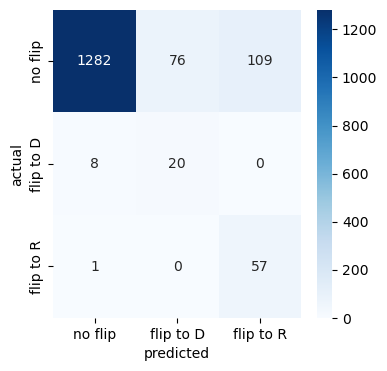

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle=True)

sample_weights = pd.Series(y_train).map({0:0.005,1:2,2:1}).values
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig,ax = plt.subplots(1,figsize=(4,4))
sns.heatmap(cm,annot=True,cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel("predicted")
ax.set_ylabel("actual")
target_labels = ["no flip","flip to D","flip to R"]
ax.set_yticklabels(target_labels)
ax.set_xticklabels(target_labels);

### classification metrics of model performance

Precision is the ratio of correctly predictied positive observations to the total predicted positives. If you care about **false positives**  (high cost), you want to have high precision. For example, false positives in cancer diagnoses could be bad because it could cause someone to undergo a taxing, unnecessary treatment. How to remember it: How **P**recise are your **P**redictions?

$$\mathrm{Precision} = \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}} = \frac{\mathrm{TP}}{\mathrm{all Predicted Positives}}$$

Recall (sensitivity or true positive rate) is the ratio of correctly predicted positive observations to all actual positives. If you care about **false negatives**, you want high recall. For example, false negatives in cancer diagnoses could be bad because it could cause someone who has cancer to not be diagnosed and therefore not treated. How to remember it: The FN doctor didn't detect the disease. 

$$\mathrm{Recall} = \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}  = \frac{\mathrm{TP}}{\mathrm{all Actual Positives}}$$


Specificity (true negative rate) is the ratio of correctly predicted negative observations to all actual negatives.
$$\mathrm{Specificity} = \frac{\mathrm{TN}}{\mathrm{TN}+\mathrm{FP}}  = \frac{\mathrm{TN}}{\mathrm{all Actual Negatives}}$$

The F1-Score is the harmonic mean of precision and recall. It balances the two, and a high F1-score indicates good performance on both metrics.

$$\mathrm{F1score} = \frac{\mathrm{Precision}\times\mathrm{Recall}}{\mathrm{Precision}+\mathrm{Recall}} $$


Support is the number of true instances for each class in the dataset (i.e., how many samples belong to each class)

### for county flip predictions, what do we care about?

We care most about maximizing the proportion of actual flipped counties in our predictions. On the other hand, it is not as important if our model predicts that counties flip when they actually don't.

1. Ideally, of all the `no flip` predictions, we want them to be highly accurate so we want high precision for `no flip`. It also important (but less so) that the actual `no flip` predictions are correctly classified so we also want high recall. `no flip` is the majority class so the precision and recall will be fairly high already.
2. For `flip to D` and `flip to R` predictions, we care about cases where we predict `no flip` but they are actually flipped! That would be a false negative. Since we care about false-negatives, we should optimize recall.
3. Again for `flip to D` and `flip to R` predictions, it's okay if they predict extra `no flip` counties (false-positives). That means the precision won't be as important in comparison to recall.




In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, 
                            y_pred = y_pred,
                            target_names=target_labels))

              precision    recall  f1-score   support

     no flip       0.99      0.87      0.93      1467
   flip to D       0.21      0.71      0.32        28
   flip to R       0.34      0.98      0.51        58

    accuracy                           0.88      1553
   macro avg       0.51      0.86      0.59      1553
weighted avg       0.95      0.88      0.90      1553



### Main takeaway from the above classification report

`flip to D` and `flip to R` have recalls of 0.71 and 0.98 which is fairly high. We were shooting for higher recall for this model so this is a good result. In words, this means that 71% (98%) of actually flipped counties were correctly predicted.


`flip to D` and `flip to R` have precisions of 0.21 and 0.34 respectively which is fairly low. This means that 21% (34%) of the predicted flipped counties are actually flipped counties. So basically this model casts a somewhat wide net on which counties are likely to flip. Of course there is huge uncertainty (i.e. media consumption, isolated major events, etc) which could have major effects that we do not capture at all in this analysis. So a lower precision would actually provide a sort of regularization effect as it helps show that we are not being over-confident and over-fitting to the data. 

In [27]:
### sanity check
true_positives = np.sum(y_test[y_pred==1])
all_actual_positive = np.sum(y_test==1)
recall = true_positives/all_actual_positive
all_pred_positive = np.sum(y_pred==1)
precision = true_positives/all_pred_positive
#print(precision, recall) #this matches expectation for 'flip to D' row

### Feature importance
Note that this feature importance includes all 3 classes (including the majority `no flip` class). Therefore this figure might be a bit misleading regarding the features that are most important for the flipped classes.

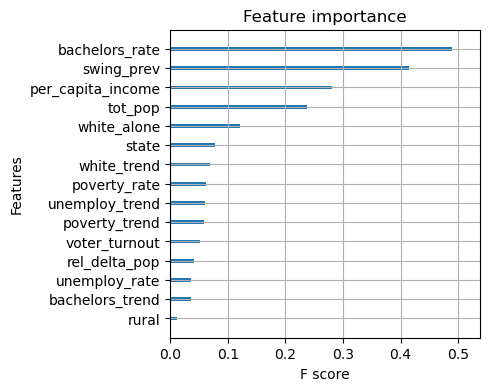

In [28]:
importance = model.get_booster().get_score(importance_type='gain')
importance.pop('party_prev', None) #removing this because it is too obvious of a feature.
fig,ax = plt.subplots(1,figsize=(4,4))
xgb.plot_importance(importance, importance_type='gain',show_values=False,ax=ax);

### comparing distributions of possibly important features

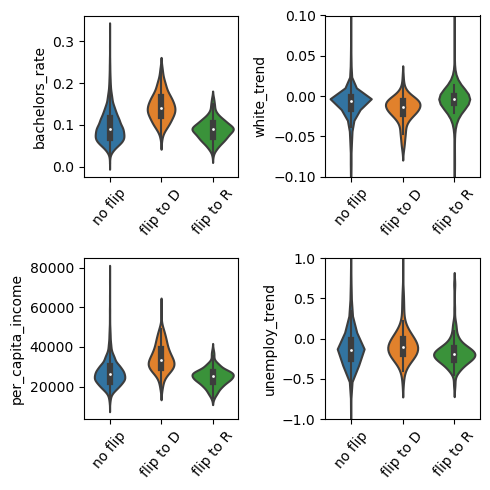

In [29]:
fig,ax = plt.subplots(2,2,figsize=(5,5))
sns.violinplot(data=df_total,y="bachelors_rate",x="flipped",ax=ax[0][0])
sns.violinplot(data=df_total,y="per_capita_income",x="flipped",ax=ax[1][0])
sns.violinplot(data=df_total,y="white_trend",x="flipped",ax=ax[0][1])
sns.violinplot(data=df_total,y="unemploy_trend",x="flipped",ax=ax[1][1])
for i in range(2):
    for j in range(2):
        ax[i][j].set_xticklabels(target_labels,rotation=50)
        ax[i][j].set_xlabel(None)
        # target_labels = ["no flip","flip to D","flip to R"]
ax[0][1].set_ylim(-0.1,.1)
ax[1][1].set_ylim(-1,1)
plt.tight_layout()

### predicting flipped counties of next election

In [30]:
X_2022 = df_total_2022[features]
y_pred_2022 = model.predict(X_2022)
df_total_2022["flipped"] = y_pred_2022

We need to make sure that the predicted flipped counties have the correct starting point. It is obviously required that the a flip to D county must have been R before and vice versa. This problem only happens 2% of the time for the flip to D counties and it doesn't happen for the flip to R counties.

In [31]:
### getting rid of double flips
test1 = df_total_2022[["county_fips","flipped"]] # flips for 2022
test2 = df_total[df_total.year=="2020"][["county_fips","flipped"]] #flips for 2020
test3 = test1.merge(test2,on='county_fips') # merging the previous two df's on fips
test4 = test3[test3.flipped_x!=0]
indices = test4[test4.flipped_x == test4.flipped_y]['county_fips'].values
# df_total_2022 = df_total_2022.set_index("county_fips")
mask_doubleflip = df_total_2022["county_fips"].isin(indices)
print(np.sum(mask_doubleflip))
df_total_2022.loc[mask_doubleflip,'flipped'] = 0

8


### Most populous predicted flipped counties

In [32]:
df_total_2022[df_total_2022["flipped"]==1].sort_values(by="totalvotes",ascending=False).head(3)[["county_fips","totalvotes","flipped"]]

,county_fips,totalvotes,flipped
1844,36103,757877,1
1245,26099,494256,1
2529,48085,490856,1


3 most populous counties predicted to flip from R to D
1. Suffolk County, NY, 40.9849° N, 72.6151° W
2. Macomb County, MI, 42.7169° N, 82.8210° W
3. Collin County, TX, 33.1795° N, 96.4930° W

In [33]:
df_total_2022[df_total_2022["flipped"]==2].sort_values(by="totalvotes",ascending=False).head(3)[["county_fips","totalvotes","flipped"]]

,county_fips,totalvotes,flipped
209,06099,214954,2
1736,33015,198798,2
2233,42049,137083,2


3 most populous counties predicted to flip from D to R
1. Stanislaus County, CA, 37.5091° N, 120.9876° W
2. Rockingham County, NH, 42.9931° N, 71.0498° W
3. Erie County, PA, 42.0522° N, 80.1875° W


### saving dataframes

In [34]:
df_total_2022.to_csv("data/df_total_2022.csv",index=False)
df_total.to_csv("data/df_total_2016-2020.csv",index=False)

See `geospatial_map_visualization.ipynb` to visualize this result.